## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
# TODO: Make all other necessary imports.
from sklearn.model_selection import train_test_split
import json


import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
tfds.disable_progress_bar()

import warnings
warnings.filterwarnings('ignore')


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
# TODO: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['test'], dataset['validation'], dataset['train']

## Explore the Dataset

In [4]:
num_examples_training = dataset_info.splits['test'].num_examples
num_examples_validation = dataset_info.splits['validation'].num_examples
num_examples_test = dataset_info.splits['train'].num_examples


num_classes = dataset_info.features['label'].num_classes

print('Number of training examples: ', num_examples_training)
print('Number of validation examples: ', num_examples_validation)
print('Number of testing examples: ', num_examples_test)
print('Number of classes: ', num_classes)

Number of training examples:  6149
Number of validation examples:  1020
Number of testing examples:  1020
Number of classes:  102


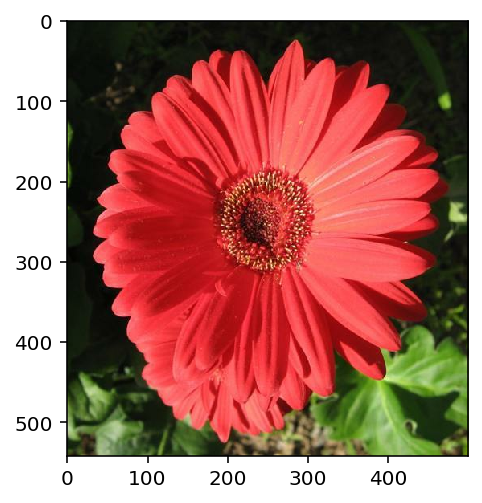

Size of the image is: (542, 500, 3)
Label of the image is: 40


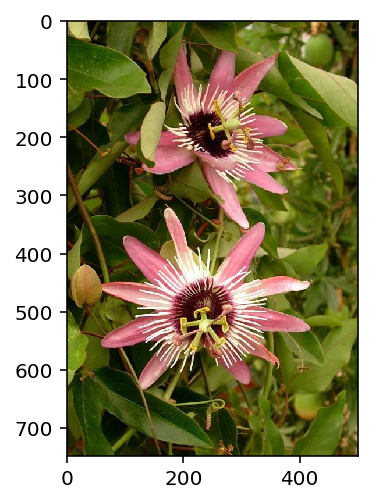

Size of the image is: (748, 500, 3)
Label of the image is: 76


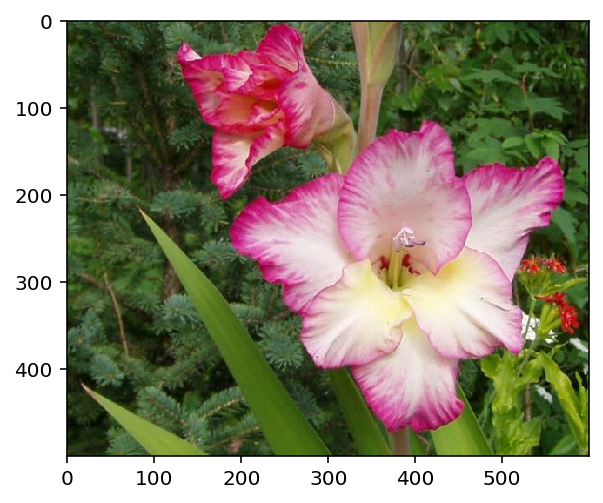

Size of the image is: (500, 600, 3)
Label of the image is: 42


In [5]:
for image, label in training_set.take(3):
    image = image.numpy()
    label = label.numpy()
    
    plt.imshow(image)
    plt.show()
    
    print("Size of the image is:", image.shape)
    print("Label of the image is:", label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

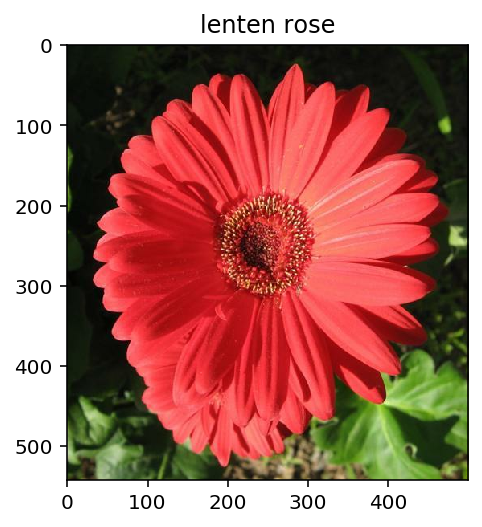

In [8]:
for image, label in training_set.take(1):
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_names[label.numpy().astype(str)])

## Create Pipeline

In [9]:
batch_size = 32
image_height = 224
image_width = 224


def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_height, image_width))
    image /= 255
    return image, label

training_batches = training_set.cache().shuffle(num_examples_training//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(normalize).batch(batch_size).prefetch(1)
test_batches = test_set.cache().map(normalize).batch(batch_size).prefetch(1)

In [10]:
for batch_image, batch_label in training_batches.take(1):
    print("Shape of batch images: ", batch_image.shape)
    print("dtype of batch images: ", batch_image.dtype)
    print(
        f"\nThere is a total of {batch_label.numpy().size} labels in this batch: "
    )
    print(batch_label.numpy())

Shape of batch images:  (32, 224, 224, 3)
dtype of batch images:  <dtype: 'float32'>

There is a total of 32 labels in this batch: 
[ 97  88  46  73  40   1  82 101   9  42  42  62  62  52  87  64  55  55
  49  47  58  39  90  59  87  76  95  47  53  88  72  49]


# Build and Train the Classifier

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 


In [11]:
# TODO: Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_height, image_width,3))
feature_extractor.trainable = False

In [12]:

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, kernel_regularizer='l2', activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               26214     
                                                                 
Total params: 2,6

In [13]:
# from workspace_utils import active_session
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 1)

epochs = 15


In [14]:
# with active_session():
history = model.fit(training_batches,
                    epochs = epochs,
                    validation_data = validation_batches,
                    callbacks = [early_stopping]
                   )

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
193/193 [==============================] - ETA: 0s - loss: 4.0489 - accuracy: 0.5242WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fda79fb50e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
193/193 [==============================] - 159s 790ms/step - loss: 4.0489 - accuracy: 0.5242 - val_loss: 2.3607 - val_accuracy: 0.6784
Epoch 2/1

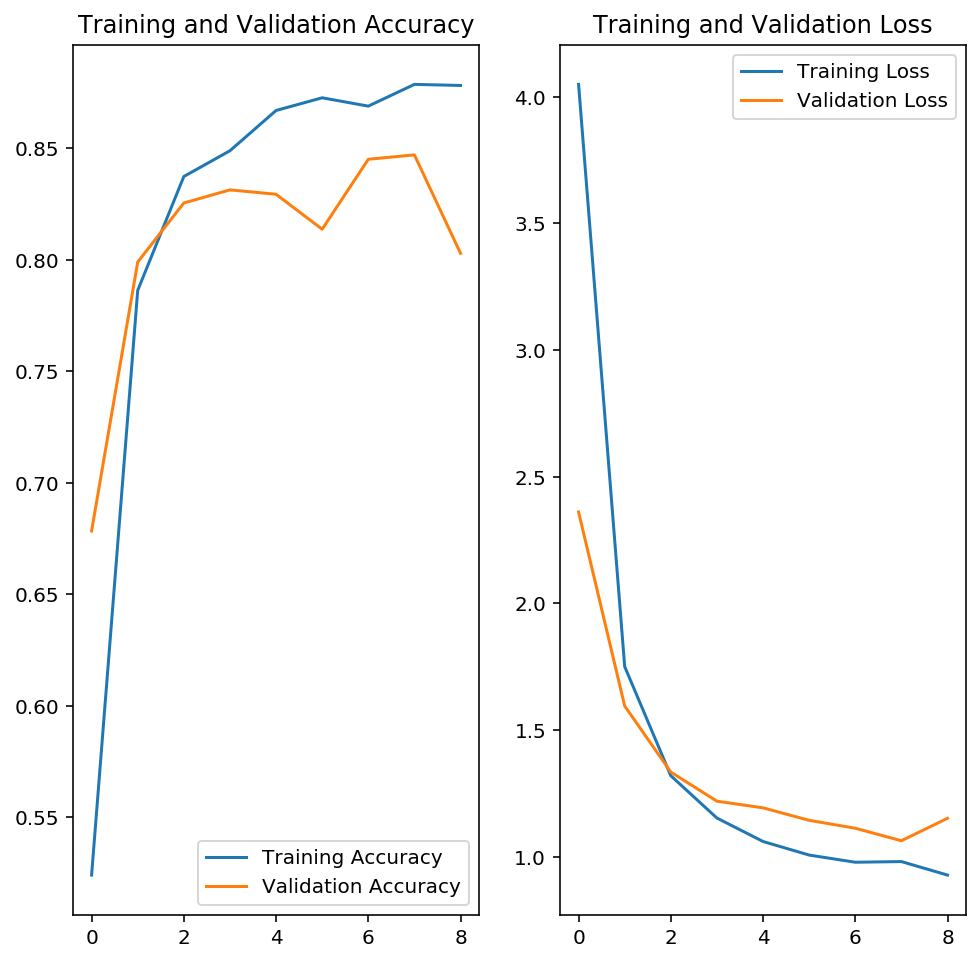

In [15]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(early_stopping.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing Model

In [16]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(test_batches)

print('\nTest set LOSS: {:,.3f}'.format(loss))
print('Test set ACCURACY: {:.3%}'.format(accuracy))

32/32 [==============================] - 22s 680ms/step - loss: 1.2116 - accuracy: 0.7961

Test set LOSS: 1.212
Test set ACCURACY: 79.608%


## Save the Model


In [17]:
saved_model_filepath = './my_saved_model.h5'

model.save(saved_model_filepath)

## Load the Keras Model


In [18]:
loaded_model = tf.keras.models.load_model(saved_model_filepath, custom_objects = {'KerasLayer' : hub.KerasLayer})
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               26214     
                                                                 
Total params: 2,612,134
Trainable params: 354,150
Non-trainable params: 2,257,984
_________________________________________________________________


## Inference for Classification



In [19]:
# TODO: Create the process_image function

def process_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, [224, 224])
    image /= 255
    return image.numpy()

To check `process_image` function i have 4 images to test:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg


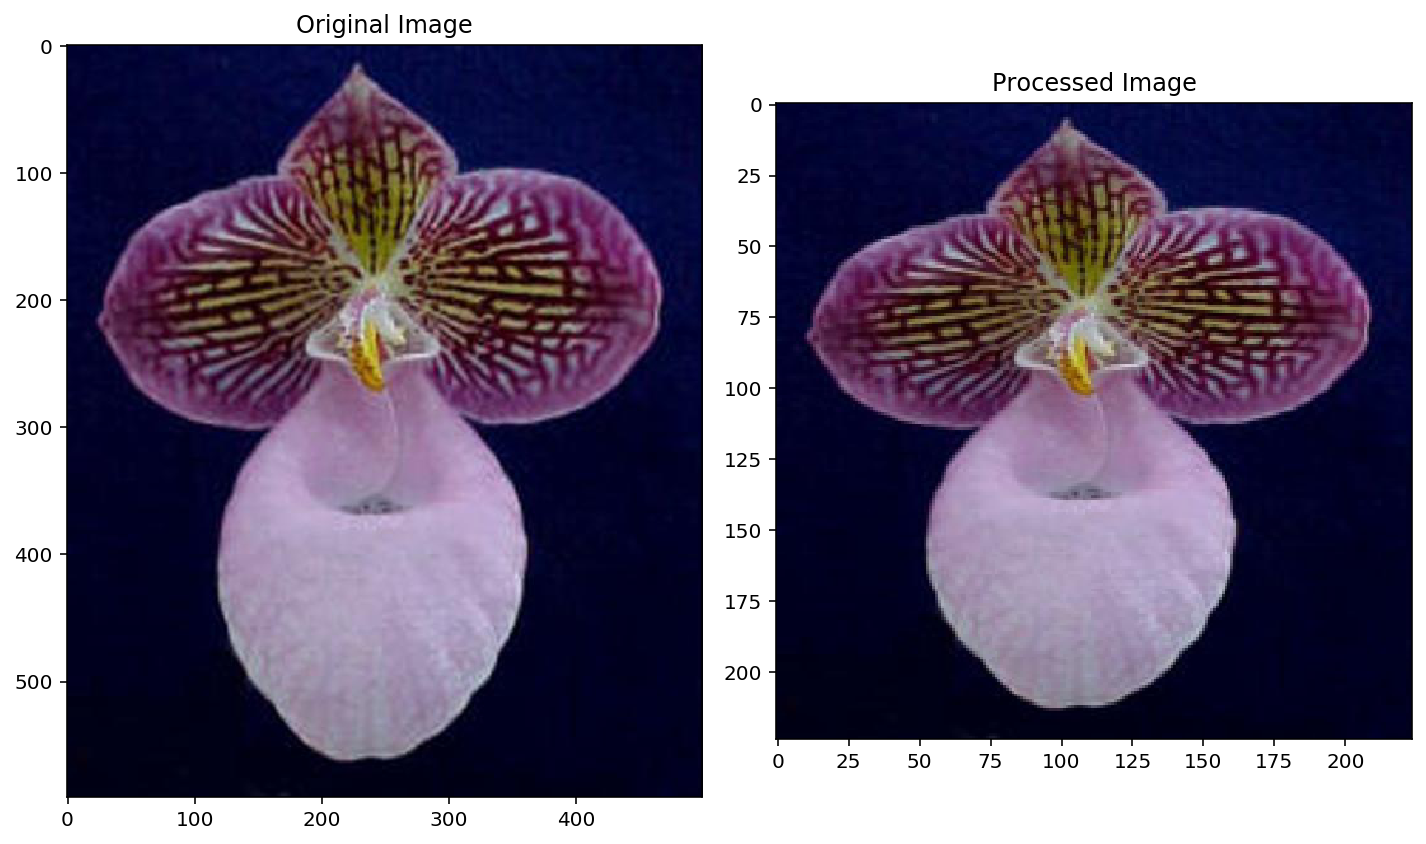

In [20]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [21]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
    # Image preparation
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    
    # Finding the top 5 probabilities with the corresponding indices
    result = tf.math.top_k(probabilities, top_k)
    
    # 'top_k_probabilities' and 'indices' are tensors of shape [1,5] and we need to use squeeze() to reduce the dimensions
    top_k_probabilities = tf.squeeze(result.values).numpy()
    indices = tf.squeeze(result.indices).numpy()
    
    # I am adding 1 to the indices, because the classes in json file start from 1 and not from 0.
    classes = [str(x + 1) for x in indices]
    
    return top_k_probabilities, classes

## Predictions Check

It's always good to check the predictions made by your model to make sure they are correct. To check predictions I tested on 4 images:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 49ms/step


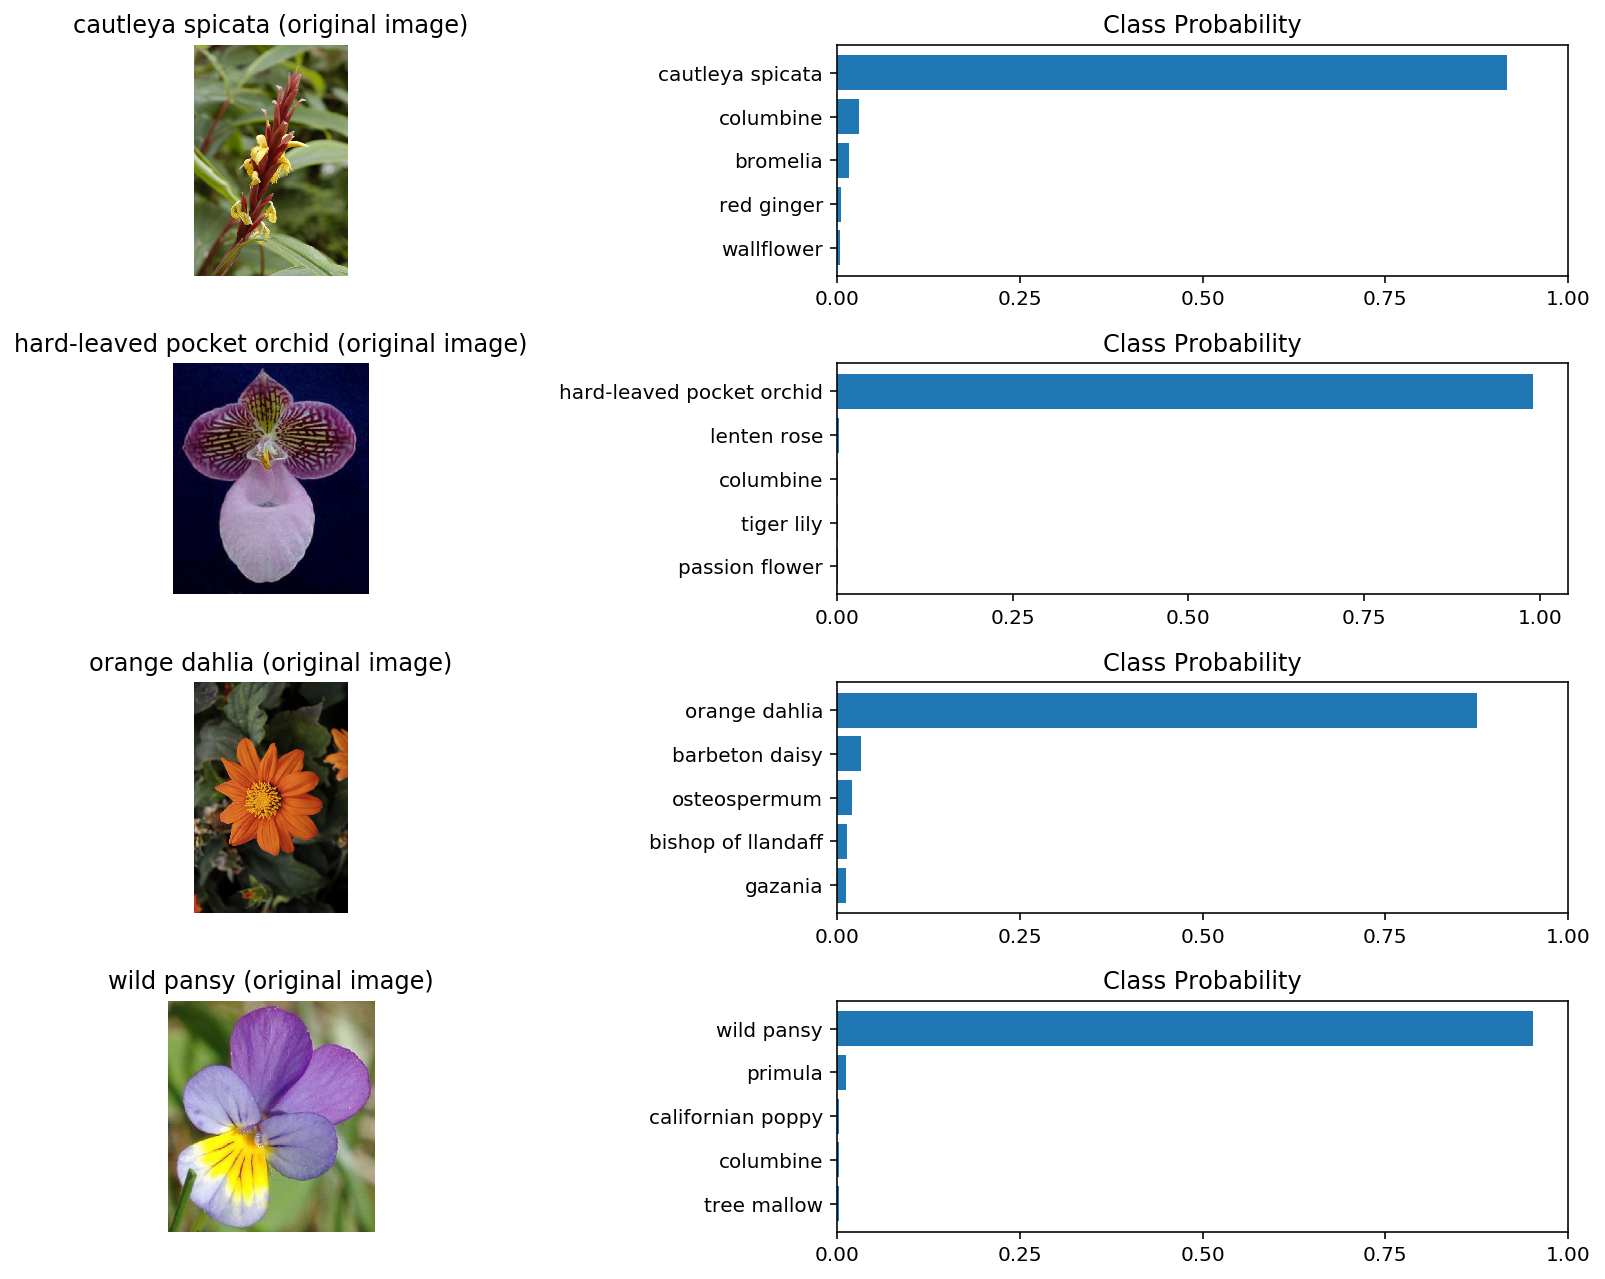

In [22]:
# TODO: Plot the input image along with the top 5 classes

flowers = ['cautleya_spicata', 'hard-leaved_pocket_orchid', 'orange_dahlia', 'wild_pansy']
fig, ax = plt.subplots(len(flowers), 2, figsize=(12, 9))

for index, flower in enumerate(flowers):
    image_path = './test_images/{}.jpg'.format(flower)
    image = Image.open(image_path)
    image = np.asarray(image)
    
    probs, classes = predict(image_path, loaded_model, 5)
    
    ax1 = ax[index][0]
    ax2 = ax[index][1]
    
    ax1.imshow(image)
    ax1.set_title(flower.replace('_', ' ') + ' (original image)')
    ax1.set_axis_off()
    
    names = [class_names[label] for label in classes]
    
    ax2.barh(np.arange(5), np.flip(probs))
    ax2.set_title('Class Probability')
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(np.flip(names))
    ax2.set_xticks(np.linspace(0, 1, 5))
    
    plt.tight_layout()
    
plt.show()